In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152, DenseNet201
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Dropout, Activation
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [ ]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [ ]:
BATCH_SIZE = 64
trdata = ImageDataGenerator()
traingen = trdata.flow_from_directory(directory='/content/gdrive/Shareddrives/TC3007C Inteligencia Artificial/Data/data_15/train',target_size=(224,224))
tsdata = ImageDataGenerator()
validgen = tsdata.flow_from_directory(directory='/content/gdrive/Shareddrives/TC3007C Inteligencia Artificial/Data/data_15/validation', target_size=(224,224))

Found 18303 images belonging to 627 classes.
Found 2302 images belonging to 627 classes.


In [ ]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=627

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [ ]:
!pip install livelossplot

In [ ]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

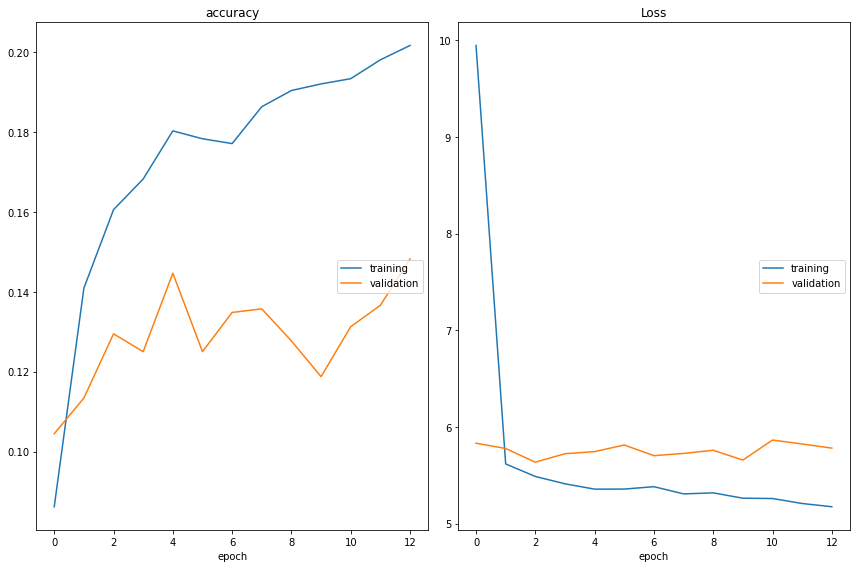

accuracy
	training         	 (min:    0.086, max:    0.202, cur:    0.202)
	validation       	 (min:    0.104, max:    0.148, cur:    0.148)
Loss
	training         	 (min:    5.174, max:    9.947, cur:    5.174)
	validation       	 (min:    5.635, max:    5.865, cur:    5.781)
285/285 [==============================] - 536s 2s/step - loss: 5.1743 - accuracy: 0.2016 - val_loss: 5.7808 - val_accuracy: 0.1482
CPU times: user 1h 55min 17s, sys: 1min 31s, total: 1h 56min 48s
Wall time: 3h 40min 51s


In [ ]:
%%time 

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [ ]:
# Reset our image data generators
traingen.reset()
validgen.reset()

# Use a smaller learning rate
optim_2 = Adam(learning_rate=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


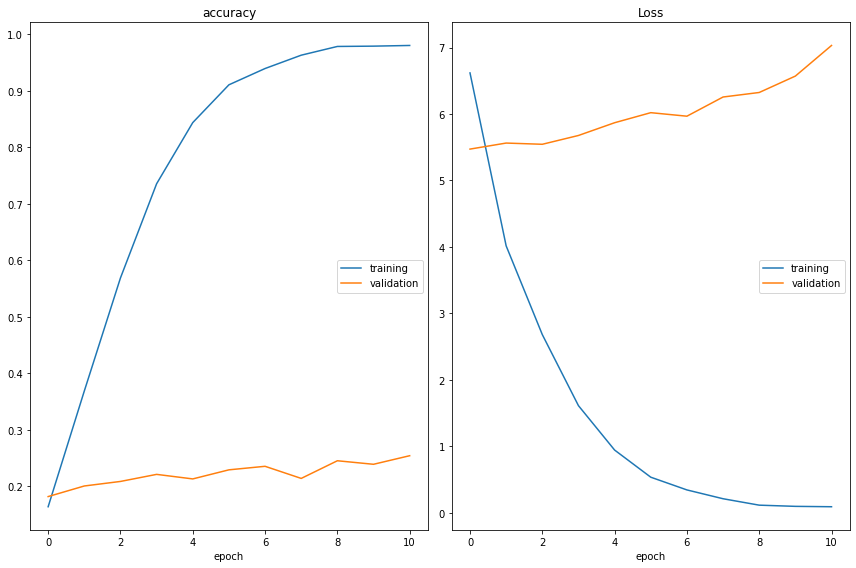

accuracy
	training         	 (min:    0.164, max:    0.980, cur:    0.980)
	validation       	 (min:    0.182, max:    0.254, cur:    0.254)
Loss
	training         	 (min:    0.093, max:    6.618, cur:    0.093)
	validation       	 (min:    5.472, max:    7.031, cur:    7.031)
285/285 [==============================] - 533s 2s/step - loss: 0.0928 - accuracy: 0.9805 - val_loss: 7.0307 - val_accuracy: 0.2545
CPU times: user 1h 37min 9s, sys: 59.6 s, total: 1h 38min 9s
Wall time: 1h 38min 25s


In [ ]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)